<a href="https://colab.research.google.com/github/tanushreedebbarma/lstm_from_scratch/blob/main/LSTM0_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import zipfile
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

In [ ]:
config = {
    "model": {
        "input_size": 12,
        "hidden_size": 128,
        "output_size": 10,
        "dropout_rate": 0.2
    },
    "training": {
        "epochs": 30,
        "learning_rate": 0.01,
        "batch_size": 32,
        "optimizer": "adam",
        "patience": 5
    },
    "data": {
        "sequence_length": 62,
        "prediction_steps": 5
    }
}

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh_derivative(x):
    return 1 - x**2

In [ ]:
class LSTM:
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.0):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_rate = dropout_rate

        def init_weight(out, inp):
            return np.random.randn(out, inp) * np.sqrt(1 / inp)

        self.W_f = init_weight(hidden_size, input_size + hidden_size)
        self.b_f = np.zeros((hidden_size, 1))

        self.W_i = init_weight(hidden_size, input_size + hidden_size)
        self.b_i = np.zeros((hidden_size, 1))

        self.W_C = init_weight(hidden_size, input_size + hidden_size)
        self.b_C = np.zeros((hidden_size, 1))

        self.W_o = init_weight(hidden_size, input_size + hidden_size)
        self.b_o = np.zeros((hidden_size, 1))

        self.W_y = init_weight(output_size, hidden_size)
        self.b_y = np.zeros((output_size, 1))

        self.m = {k: 0 for k in ["W_f", "b_f", "W_i", "b_i", "W_C", "b_C", "W_o", "b_o", "W_y", "b_y"]}
        self.v = {k: 0 for k in self.m}

    def forward_sequence(self, x_seq, training=True):
        h, C = np.zeros((self.hidden_size, 1)), np.zeros((self.hidden_size, 1))
        states = []

        for x_t in x_seq:
            x_t = x_t.reshape(-1, 1)
            concat = np.vstack((h, x_t))
            f = sigmoid(np.dot(self.W_f, concat) + self.b_f)
            i = sigmoid(np.dot(self.W_i, concat) + self.b_i)
            C_bar = tanh(np.dot(self.W_C, concat) + self.b_C)
            C = f * C + i * C_bar
            o = sigmoid(np.dot(self.W_o, concat) + self.b_o)
            h = o * tanh(C)

            if self.dropout_rate > 0 and training:
                dropout_mask = (np.random.rand(*h.shape) > self.dropout_rate).astype(np.float32)
                h *= dropout_mask / (1.0 - self.dropout_rate)

            states.append((h.copy(), C.copy(), f, i, C_bar, o, concat))
        return states

    def output(self, h):
        return np.dot(self.W_y, h) + self.b_y

    def bptt(self, states, y_true):
        y_pred = self.output(states[-1][0])
        loss = np.mean((y_true - y_pred) ** 2)
        d_y = 2 * (y_pred - y_true) / y_true.shape[0]

        grads = {k: np.zeros_like(getattr(self, k)) for k in self.__dict__ if k.startswith('W_') or k.startswith('b_')}
        grads["W_y"] = np.dot(d_y, states[-1][0].T)
        grads["b_y"] = d_y

        dh_next = np.dot(self.W_y.T, d_y)
        dC_next = np.zeros((self.hidden_size, 1))

        for t in reversed(range(len(states))):
            h, C, f, i, C_bar, o, concat = states[t]
            tanh_C = tanh(C)
            d_o = dh_next * tanh_C * sigmoid_derivative(o)
            dC = dh_next * o * tanh_derivative(tanh_C) + dC_next
            d_f = dC * states[t - 1][1] * sigmoid_derivative(f) if t > 0 else np.zeros_like(f)
            d_i = dC * C_bar * sigmoid_derivative(i)
            d_C_bar = dC * i * tanh_derivative(C_bar)

            grads["W_f"] += np.dot(d_f, concat.T)
            grads["b_f"] += d_f
            grads["W_i"] += np.dot(d_i, concat.T)
            grads["b_i"] += d_i
            grads["W_C"] += np.dot(d_C_bar, concat.T)
            grads["b_C"] += d_C_bar
            grads["W_o"] += np.dot(d_o, concat.T)
            grads["b_o"] += d_o

            d_concat = (
                np.dot(self.W_f.T, d_f)
                + np.dot(self.W_i.T, d_i)
                + np.dot(self.W_C.T, d_C_bar)
                + np.dot(self.W_o.T, d_o)
            )
            dh_next = d_concat[:self.hidden_size, :]
            dC_next = dC * f

        return loss, grads

    def update_weights(self, lr, grads, optimizer="sgd", beta1=0.9, beta2=0.999, epsilon=1e-8, t=1):
        for k in grads:
            grad = np.clip(grads[k], -1, 1)
            if optimizer == "adam":
                self.m[k] = beta1 * self.m[k] + (1 - beta1) * grad
                self.v[k] = beta2 * self.v[k] + (1 - beta2) * (grad ** 2)
                m_hat = self.m[k] / (1 - beta1 ** t)
                v_hat = self.v[k] / (1 - beta2 ** t)
                setattr(self, k, getattr(self, k) - lr * m_hat / (np.sqrt(v_hat) + epsilon))
            else:
                setattr(self, k, getattr(self, k) - lr * grad)

In [ ]:
def normalize_data(file_data):
    means = np.mean(file_data, axis=0)
    std_devs = np.std(file_data, axis=0)
    std_devs[std_devs == 0] = 1
    return (file_data - means) / std_devs

def load_data_from_folder(base_dir='car_data'):
    data = []
    for file in glob.glob(os.path.join(base_dir, '**/*.csv'), recursive=True):
        try:
            df = pd.read_csv(file).dropna()
            file_data = normalize_data(df.values)
            if file_data.shape[0] >= 67 and file_data.shape[1] >= 12:
                data.append(file_data)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    print(f"Loaded {len(data)} valid files.")
    return data

def preprocess_data(data, sequence_length=62, prediction_steps=5):
    X, y = [], []
    for file_data in data:
        max_start = len(file_data) - sequence_length - prediction_steps + 1
        if max_start <= 0:
            continue
        for i in range(max_start):
            X.append(file_data[i:i+sequence_length, :])
            y.append(file_data[i+sequence_length:i+sequence_length+prediction_steps, :2].flatten())
    print(f"Total sequences extracted: {len(X)}")
    return np.array(X), np.array(y)

In [ ]:
def learning_rate_schedule(epoch, base_lr=0.01, decay_rate=0.1, decay_steps=10):
    return base_lr * math.pow(decay_rate, epoch // decay_steps)

def train_lstm(lstm, X_train, y_train, X_val, y_val, epochs=30, learning_rate=0.01, patience=5, optimizer='adam'):
      best_val_loss = float('inf')
      wait = 0

      for epoch in range(epochs):
        lr = learning_rate_schedule(epoch, base_lr=learning_rate)
        print(f"Epoch {epoch + 1}/{epochs} | LR: {lr:.6f}")

        indices = np.random.permutation(len(X_train))
        total_loss = 0

        for idx in indices:
            x_seq = X_train[idx]
            y_target = y_train[idx].reshape(-1, 1)
            states = lstm.forward_sequence(x_seq, training=True)
            loss, grads = lstm.bptt(states, y_target)
            total_loss += loss
            lstm.update_weights(lr, grads, optimizer=optimizer)

        val_preds = [lstm.output(lstm.forward_sequence(x, training=False)[-1][0]) for x in X_val]
        val_loss = mean_squared_error(y_val, np.array(val_preds).squeeze())

        print(f"Train Loss: {total_loss / len(X_train):.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

In [ ]:
def evaluate_lstm(lstm, X_test, y_test, verbose=True):
    predictions = []
    for x_seq in X_test:
        states = lstm.forward_sequence(x_seq, training=False)
        y_pred = lstm.output(states[-1][0]).reshape(5, 2)
        predictions.append(y_pred)

    predictions = np.array(predictions)
    rmse = np.sqrt(np.mean((predictions - y_test.reshape(-1, 5, 2)) ** 2))
    print(f"Test RMSE: {rmse:.4f}")

    if verbose:
        plt.figure(figsize=(8, 6))
        for i in range(min(5, len(predictions))):
            true_coords = y_test[i].reshape(5, 2)
            plt.plot(true_coords[:, 0], true_coords[:, 1], label=f'True Path {i+1}', marker='o')
            plt.plot(predictions[i, :, 0], predictions[i, :, 1], label=f'Pred Path {i+1}', marker='x')
        plt.legend()
        plt.title("LSTM Prediction vs Actual (x, y)")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.show()
    return rmse

In [ ]:
def print_true_vs_predicted(lstm, X_test, y_test, num_examples=5):
    for i in range(min(num_examples, len(X_test))):
        states = lstm.forward_sequence(X_test[i], training=False)
        y_pred = lstm.output(states[-1][0]).reshape(5, 2)
        y_true = y_test[i].reshape(5, 2)

        print(f"\nExample {i + 1}")
        print(f"{'Timestep':>8} | {'True X':>8} {'True Y':>8} || {'Pred X':>8} {'Pred Y':>8}")
        print("-" * 45)
        for t in range(5):
            tx, ty = y_true[t]
            px, py = y_pred[t]
            print(f"{t + 1:>8} | {tx:>8.4f} {ty:>8.4f} || {px:>8.4f} {py:>8.4f}")

In [ ]:
def save_results(results, file_path='lstm_results.csv'):
    df = pd.DataFrame([results])
    if os.path.exists(file_path):
        df.to_csv(file_path, mode='a', header=False, index=False)
    else:
        df.to_csv(file_path, index=False)

In [ ]:
!unzip /content/Car_data.zip

File_paths = glob.glob('/content/Car_data')
train_folder = r"/content/car_data"

Streaming output truncated to the last 5000 lines.
  inflating: car_data/14730.csv      
  inflating: __MACOSX/car_data/._14730.csv  
  inflating: car_data/1518.csv       
  inflating: __MACOSX/car_data/._1518.csv  
  inflating: car_data/12355.csv      
  inflating: __MACOSX/car_data/._12355.csv  
  inflating: car_data/14724.csv      
  inflating: __MACOSX/car_data/._14724.csv  
  inflating: car_data/10542.csv      
  inflating: __MACOSX/car_data/._10542.csv  
  inflating: car_data/11884.csv      
  inflating: __MACOSX/car_data/._11884.csv  
  inflating: car_data/16133.csv      
  inflating: __MACOSX/car_data/._16133.csv  
  inflating: car_data/16655.csv      
  inflating: __MACOSX/car_data/._16655.csv  
  inflating: car_data/10224.csv      
  inflating: __MACOSX/car_data/._10224.csv  
  inflating: car_data/14042.csv      
  inflating: __MACOSX/car_data/._14042.csv  
  inflating: car_data/12433.csv      
  inflating: __MACOSX/car_data/._12433.csv  
  inflating: car_data/1281.csv       

Loaded 9400 valid files.
Total sequences extracted: 9400
Epoch 1/30 | LR: 0.010000
Train Loss: 0.200017 | Val Loss: 0.166128
Epoch 2/30 | LR: 0.010000
Train Loss: 0.156148 | Val Loss: 0.130562
Epoch 3/30 | LR: 0.010000
Train Loss: 0.135899 | Val Loss: 0.121306
Epoch 4/30 | LR: 0.010000
Train Loss: 0.116349 | Val Loss: 0.103829
Epoch 5/30 | LR: 0.010000
Train Loss: 0.102099 | Val Loss: 0.096960
Epoch 6/30 | LR: 0.010000
Train Loss: 0.091248 | Val Loss: 0.093731
Epoch 7/30 | LR: 0.010000
Train Loss: 0.084451 | Val Loss: 0.077523
Epoch 8/30 | LR: 0.010000
Train Loss: 0.077284 | Val Loss: 0.091091
Epoch 9/30 | LR: 0.010000
Train Loss: 0.073171 | Val Loss: 0.078339
Epoch 10/30 | LR: 0.010000
Train Loss: 0.069216 | Val Loss: 0.076292
Epoch 11/30 | LR: 0.001000
Train Loss: 0.047275 | Val Loss: 0.057752
Epoch 12/30 | LR: 0.001000
Train Loss: 0.041071 | Val Loss: 0.056242
Epoch 13/30 | LR: 0.001000
Train Loss: 0.037418 | Val Loss: 0.054916
Epoch 14/30 | LR: 0.001000
Train Loss: 0.035064 | Val L

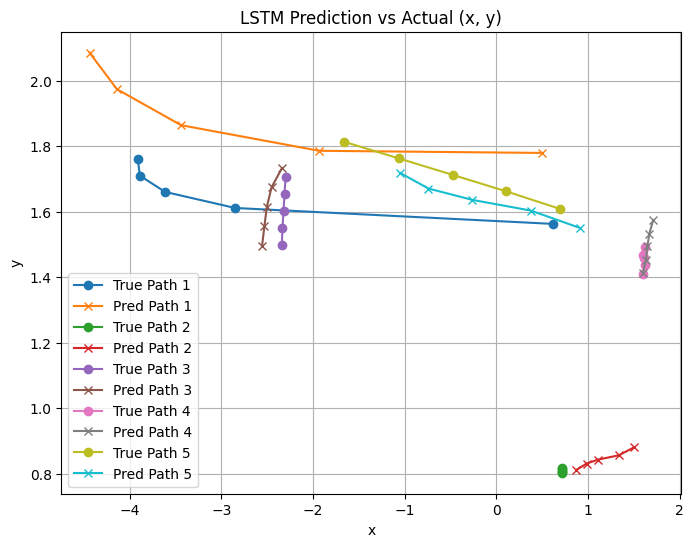

In [ ]:
data = load_data_from_folder()
X, y = preprocess_data(data, sequence_length=config["data"]["sequence_length"],
                       prediction_steps=config["data"]["prediction_steps"])

if len(X) > 0:
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, random_state=42)

    lstm = LSTM(input_size=config["model"]["input_size"],
                hidden_size=config["model"]["hidden_size"],
                output_size=config["model"]["output_size"])

    train_lstm(lstm, X_train, y_train, X_val, y_val,
               epochs=config["training"]["epochs"],
               learning_rate=config["training"]["learning_rate"],
               patience=config["training"]["patience"])

    rmse = evaluate_lstm(lstm, X_test, y_test)

    results = {
        "learning_rate": config["training"]["learning_rate"],
        "epochs": config["training"]["epochs"],
        "hidden_size": config["model"]["hidden_size"],
        "rmse": rmse
    }
    save_results(results)
else:
    print("Not enough data to train.")

In [ ]:
print_true_vs_predicted(lstm, X_test, y_test)


Example 1
Timestep |   True X   True Y ||   Pred X   Pred Y
---------------------------------------------
       1 |   0.6196   1.5630 ||   0.5030   1.7796
       2 |  -2.8500   1.6116 ||  -1.9322   1.7862
       3 |  -3.6135   1.6606 ||  -3.4387   1.8643
       4 |  -3.8886   1.7101 ||  -4.1387   1.9742
       5 |  -3.9110   1.7597 ||  -4.4374   2.0856

Example 2
Timestep |   True X   True Y ||   Pred X   Pred Y
---------------------------------------------
       1 |   0.7147   0.8032 ||   0.8750   0.8120
       2 |   0.7147   0.8065 ||   0.9860   0.8311
       3 |   0.7147   0.8098 ||   1.1105   0.8431
       4 |   0.7147   0.8131 ||   1.3383   0.8565
       5 |   0.7176   0.8163 ||   1.5007   0.8803

Example 3
Timestep |   True X   True Y ||   Pred X   Pred Y
---------------------------------------------
       1 |  -2.3401   1.4979 ||  -2.5551   1.4963
       2 |  -2.3326   1.5501 ||  -2.5292   1.5573
       3 |  -2.3214   1.6022 ||  -2.5035   1.6146
       4 |  -2.3102   1.6544 

Loaded 9400 valid files.
Total sequences extracted: 9400
Epoch 1/30 | LR: 0.010000
Train Loss: 0.190816 | Val Loss: 0.203671
Epoch 2/30 | LR: 0.010000
Train Loss: 0.149031 | Val Loss: 0.183238
Epoch 3/30 | LR: 0.010000
Train Loss: 0.138442 | Val Loss: 0.179966
Epoch 4/30 | LR: 0.010000
Train Loss: 0.131254 | Val Loss: 0.165129
Epoch 5/30 | LR: 0.010000
Train Loss: 0.120702 | Val Loss: 0.162620
Epoch 6/30 | LR: 0.010000
Train Loss: 0.115741 | Val Loss: 0.147465
Epoch 7/30 | LR: 0.010000
Train Loss: 0.108611 | Val Loss: 0.150219
Epoch 8/30 | LR: 0.010000
Train Loss: 0.101566 | Val Loss: 0.141001
Epoch 9/30 | LR: 0.010000
Train Loss: 0.092918 | Val Loss: 0.132720
Epoch 10/30 | LR: 0.010000
Train Loss: 0.086741 | Val Loss: 0.135162
Epoch 11/30 | LR: 0.001000
Train Loss: 0.065766 | Val Loss: 0.115338
Epoch 12/30 | LR: 0.001000
Train Loss: 0.055886 | Val Loss: 0.111714
Epoch 13/30 | LR: 0.001000
Train Loss: 0.050640 | Val Loss: 0.108052
Epoch 14/30 | LR: 0.001000
Train Loss: 0.046683 | Val L

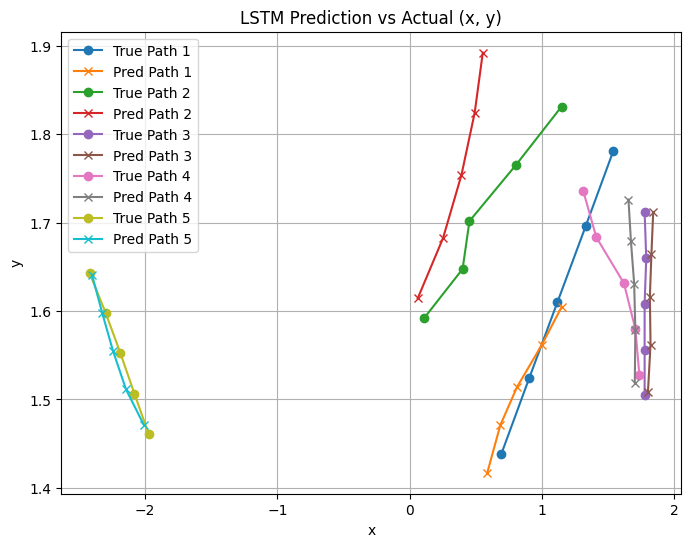

In [ ]:
data = load_data_from_folder()
X, y = preprocess_data(data, sequence_length=config["data"]["sequence_length"],
                       prediction_steps=config["data"]["prediction_steps"])

if len(X) > 0:
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, random_state=42)

    lstm = LSTM(input_size=config["model"]["input_size"],
                hidden_size=config["model"]["hidden_size"],
                output_size=config["model"]["output_size"])

    train_lstm(lstm, X_train, y_train, X_val, y_val,
               epochs=config["training"]["epochs"],
               learning_rate=config["training"]["learning_rate"],
               patience=config["training"]["patience"])

    rmse = evaluate_lstm(lstm, X_test, y_test)

    results = {
        "learning_rate": config["training"]["learning_rate"],
        "epochs": config["training"]["epochs"],
        "hidden_size": config["model"]["hidden_size"],
        "rmse": rmse
    }
    save_results(results)
else:
    print("Not enough data to train.")

Loaded 9400 valid files.
Total sequences extracted: 9400
Epoch 1/30 | LR: 0.010000
Train Loss: 0.243069 | Val Loss: 0.175492
Epoch 2/30 | LR: 0.010000
Train Loss: 0.206593 | Val Loss: 0.195011
Epoch 3/30 | LR: 0.010000
Train Loss: 0.198314 | Val Loss: 0.167152
Epoch 4/30 | LR: 0.010000
Train Loss: 0.193952 | Val Loss: 0.174948
Epoch 5/30 | LR: 0.010000
Train Loss: 0.188651 | Val Loss: 0.166580
Epoch 6/30 | LR: 0.010000
Train Loss: 0.188789 | Val Loss: 0.157192
Epoch 7/30 | LR: 0.010000
Train Loss: 0.184271 | Val Loss: 0.160982
Epoch 8/30 | LR: 0.010000
Train Loss: 0.183010 | Val Loss: 0.154927
Epoch 9/30 | LR: 0.010000
Train Loss: 0.180365 | Val Loss: 0.173962
Epoch 10/30 | LR: 0.010000
Train Loss: 0.186088 | Val Loss: 0.164679
Epoch 11/30 | LR: 0.001000
Train Loss: 0.167263 | Val Loss: 0.143094
Epoch 12/30 | LR: 0.001000
Train Loss: 0.154700 | Val Loss: 0.138943
Epoch 13/30 | LR: 0.001000
Train Loss: 0.152368 | Val Loss: 0.137613
Epoch 14/30 | LR: 0.001000
Train Loss: 0.146458 | Val L

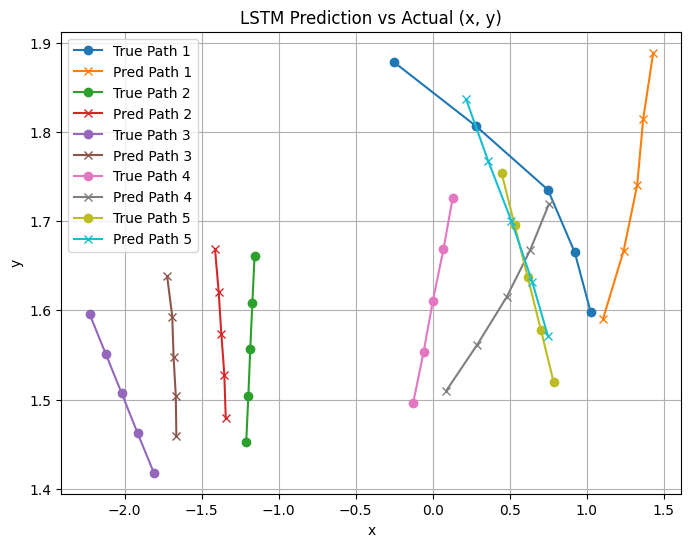

In [ ]:
data = load_data_from_folder()
X, y = preprocess_data(data, sequence_length=config["data"]["sequence_length"],
                       prediction_steps=config["data"]["prediction_steps"])

if len(X) > 0:
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, random_state=42)

    lstm = LSTM(input_size=config["model"]["input_size"],
            hidden_size=config["model"]["hidden_size"],
            output_size=config["model"]["output_size"],
            dropout_rate=config["model"]["dropout_rate"])

    train_lstm(lstm, X_train, y_train, X_val, y_val,
               epochs=config["training"]["epochs"],
               learning_rate=config["training"]["learning_rate"],
               patience=config["training"]["patience"])

    rmse = evaluate_lstm(lstm, X_test, y_test)

    results = {
        "learning_rate": config["training"]["learning_rate"],
        "epochs": config["training"]["epochs"],
        "hidden_size": config["model"]["hidden_size"],
        "rmse": rmse
    }
    save_results(results)
else:
    print("Not enough data to train.")

In [ ]:
print_true_vs_predicted(lstm, X_test, y_test)


Example 1
Timestep |   True X   True Y ||   Pred X   Pred Y
---------------------------------------------
       1 |   1.0259   1.5982 ||   1.1067   1.5907
       2 |   0.9223   1.6652 ||   1.2401   1.6670
       3 |   0.7481   1.7354 ||   1.3277   1.7402
       4 |   0.2821   1.8067 ||   1.3673   1.8151
       5 |  -0.2499   1.8784 ||   1.4322   1.8891

Example 2
Timestep |   True X   True Y ||   Pred X   Pred Y
---------------------------------------------
       1 |  -1.2110   1.4524 ||  -1.3440   1.4793
       2 |  -1.1971   1.5045 ||  -1.3533   1.5281
       3 |  -1.1849   1.5565 ||  -1.3729   1.5740
       4 |  -1.1710   1.6085 ||  -1.3901   1.6211
       5 |  -1.1571   1.6606 ||  -1.4136   1.6687

Example 3
Timestep |   True X   True Y ||   Pred X   Pred Y
---------------------------------------------
       1 |  -1.8110   1.4178 ||  -1.6646   1.4591
       2 |  -1.9169   1.4624 ||  -1.6685   1.5042
       3 |  -2.0196   1.5069 ||  -1.6828   1.5478
       4 |  -2.1240   1.5515 